# Noisy QSVDD Preparation

In [1]:
# Declare the normal class and the dimension of the latent space
# For QSVDD: num_params_conv <- 15, cost_func <- 'svdd', steps = 500
# For QAE: num_params_conv <- 8, cost_func <- 'qae', steps = 2000

# dataset <- 'mnist', 'fmnist', 'cifar'
# ntrain <- number of class want to train
# latent_dim <- 3, 6, 9, 12, 15

dataset = 'mnist'
ntrain = 0 ; latent_dim = 9
num_params_conv = 15 
cost_func = 'svdd'
steps = 500
learning_rate = 0.001
batch_size = 16


In [2]:
# Import libraries

from pennylane import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pennylane as qml


c:\Users\user1\anaconda3\envs\venv\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
import sys
sys.version

'3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]'

In [4]:
# Import data

def data(ntrain, latent_dim, dataset):
    if dataset == 'mnist':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    elif dataset == 'fmnist':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
        

    x_train, x_test = x_train[..., np.newaxis] / 255.0, x_test[..., np.newaxis] / 255.0  # normalize the data

    x_train_filter = np.where(y_train == ntrain)
    x_test_filter = np.where(y_test == ntrain)

    X_train = x_train[x_train_filter]
    X_test = x_test[x_test_filter]
    Y_train = y_train[x_train_filter]
    Y_test = y_test[x_test_filter]


    train_indices = np.random.choice(len(X_train), 600, replace=False)
    test_indices = np.random.choice(len(X_test), 100, replace=False)

    X_train = X_train[train_indices]
    X_test = X_test[test_indices]
    Y_train = Y_train[train_indices]
    Y_test = Y_test[test_indices]

    X_train = tf.image.resize(X_train[:], (256, 1)).numpy()
    X_test = tf.image.resize(X_test[:], (256, 1)).numpy()
    X_train, X_test = tf.squeeze(X_train).numpy(), tf.squeeze(X_test).numpy()

    x_train = tf.image.resize(x_train[:], (256, 1)).numpy()
    x_test = tf.image.resize(x_test[:], (256, 1)).numpy()
    x_train, x_test = tf.squeeze(x_train).numpy(), tf.squeeze(x_test).numpy()

    center = qml.numpy.zeros(latent_dim, requires_grad=True)
    center_train = np.tile(center,(len(X_train),1))
    print('x_train:',x_train.shape)
    print('x_test:',x_test.shape)
    print('X_train:',X_train.shape)
    print('X_test:',X_test.shape)
    print('Y_train:',Y_train.shape)
    print('Y_test:',Y_test.shape)
    return x_train, y_train, x_test, y_test, X_train, X_test, Y_train, Y_test, center_train


In [5]:
x_train, y_train, x_test, y_test, X_train, X_test, Y_train, Y_test, center_train = data(ntrain, latent_dim, dataset)

x_train: (60000, 256)
x_test: (10000, 256)
X_train: (600, 256)
X_test: (100, 256)
Y_train: (600,)
Y_test: (100,)


In [6]:
# Data embedding

from pennylane.templates.embeddings import AmplitudeEmbedding

def data_embedding(X, embedding_type='Amplitude'):
    if embedding_type == 'Amplitude':
        AmplitudeEmbedding(X, wires=range(8), normalize=True)

In [7]:
# Unitary

def U_SU4(params, wires): # 15 params
    qml.U3(params[0], params[1], params[2], wires=wires[0])
    qml.U3(params[3], params[4], params[5], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[6], wires=wires[0])
    qml.RZ(params[7], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[8], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.U3(params[9], params[10], params[11], wires=wires[0])
    qml.U3(params[12], params[13], params[14], wires=wires[1])

from itertools import combinations
def U_QAE(params): # params: 14
    nqubits = 8
    ntrash = 6
    for i in range(nqubits):
        qml.RY(params[i], wires = i)
        
    for i,j in combinations(range(0, ntrash), 2): # CZ between trash qubits
        qml.CZ(wires = [i, j])
        
    for idx in range(ntrash): # CZ between trash and non-trash qubits
        for i in range(ntrash):
            for j in range(ntrash+i,nqubits,ntrash):
                qml.CZ(wires = [(idx+i)%(ntrash),j])       

def U_QAE_last(params):
    ntrash = 6
    for i in range(ntrash):
        qml.RY(params[i], wires = i)

In [8]:
# Convolution layer

def conv_layer_1(U, params):
    for i in range(0, 8, 2):
        U(params, wires=[i, i + 1])
    for i in range(1, 7, 2):
        U(params, wires=[i, i + 1])
    U(params, wires=[7,0])

def conv_layer_2(U, params):
    U(params, wires=[2,4])
    U(params, wires=[6,0])
    U(params, wires=[0,2])
    U(params, wires=[4,6])
    
def conv_layer_3(U, params):
    U(params, wires=[2,6])
    
def QCNN_structure_without_pooling(U, params, U_params): #75
    param1 = params[0:U_params]
    param2 = params[U_params: 2 * U_params]
    param3 = params[2 * U_params: 3 * U_params]
    param4 = params[3 * U_params: 4 * U_params]
    param5 = params[4 * U_params: 5 * U_params]

    conv_layer_1(U, param1)
    conv_layer_1(U, param2)
    conv_layer_2(U, param3)
    conv_layer_2(U, param4)
    conv_layer_3(U, param5)
    
def QSVDD_QAE(U, params, U_params):
    param1 = params[0:U_params]
    param2 = params[U_params: 2 * U_params]
    param3 = params[2 * U_params: 3 * U_params]
    param4 = params[3 * U_params: 4 * U_params]
    param5 = params[4 * U_params: 5 * U_params]    
    param6 = params[5 * U_params: 6 * U_params]
    param7 = params[6 * U_params: 7 * U_params]
    param8 = params[7 * U_params: 8 * U_params]
    param9 = params[8 * U_params: 9 * U_params]
    param10 = params[9 * U_params: 78]
    
    U_QAE(param1)
    U_QAE(param2)
    U_QAE(param3)
    U_QAE(param4)
    U_QAE(param5)
    U_QAE(param6)
    U_QAE(param7)
    U_QAE(param8)
    U_QAE(param9)
    U_QAE_last(param10)


# Training

In [9]:

def qae_loss(Y, predictions):
    loss = 0
    for l, p in zip(Y, predictions):
        loss = loss + (-np.sum(p))
    loss = loss / len(Y)
    return loss

def svdd_loss(Y, predictions):
    loss = 0
    for l, p in zip(Y, predictions):
        loss = loss + np.sum(np.array(p-l)**2)
    loss = loss / len(Y)
    return loss

    # Cost
def cost(params, X, Y, U_params, latent_dim, cost_fn):
    predictions = np.array([QCNN(x, params, U_params, latent_dim, cost_fn) for x in X])
    if cost_fn == 'qae':
        loss_value = qae_loss(Y, predictions)

    elif cost_fn == 'svdd':

        loss_value = np.square(np.subtract(predictions, Y)).mean()

    return loss_value
def circuit_training(X_train, Y_train, U_params, cost_fn, latent_dim):
    
    if cost_fn == 'qae':
        params = np.random.randn(78, requires_grad = True)

    elif cost_fn == 'svdd':    
        params = np.random.randn(U_params * 5, requires_grad = True)

    opt = qml.AdamOptimizer(stepsize=learning_rate)    

    param_history= [params]
    loss_history = []

    for it in range(steps):

        batch_index = np.random.randint(0, len(X_train), (batch_size,))
        X_batch = np.array([X_train[i] for i in batch_index])
        Y_batch = np.array([Y_train[i] for i in batch_index])

        params, cost_new = opt.step_and_cost(lambda v: cost(v, X_batch, Y_batch, U_params, latent_dim, cost_fn), params)
        param_history.append(params)
        loss_history.append(cost_new)


        print("iteration: ", it, " cost: ", cost_new)


    return loss_history, params, param_history


In [10]:
# QCNN
from pennylane import numpy as np

dev = qml.device('default.qubit', wires = 8)
@qml.qnode(dev, interface = 'autograd', diff_method = 'backprop')

def QCNN(X, params, U_params, latent_dim, cost_fn):
    # Data embedding
    data_embedding(X, embedding_type='Amplitude')
    
    if cost_fn == 'qae':
        QSVDD_QAE(U_QAE, params, U_params)
        result = [qml.expval(qml.PauliZ(i)) for i in (0,1,2,3,4,5)]
    elif cost_fn == 'qae_test':
        QSVDD_QAE(U_QAE, params, U_params)
        if latent_dim == 9:
            result =[qml.expval(qml.PauliX(6)),qml.expval(qml.PauliY(6)),qml.expval(qml.PauliZ(6)), 
                        qml.expval(qml.PauliX(7)),qml.expval(qml.PauliY(7)),qml.expval(qml.PauliZ(7)),
                        qml.expval(qml.PauliX(6) @ qml.PauliX(7)), qml.expval(qml.PauliY(6) @ qml.PauliY(7)), 
                        qml.expval(qml.PauliZ(6) @ qml.PauliZ(7))]
        elif latent_dim == 15:
            result = [qml.expval(qml.PauliX(6)),qml.expval(qml.PauliY(6)),qml.expval(qml.PauliZ(6)), 
                        qml.expval(qml.PauliX(7)),qml.expval(qml.PauliY(7)),qml.expval(qml.PauliZ(7)),
                        qml.expval(qml.PauliX(6) @ qml.PauliX(7)), qml.expval(qml.PauliY(6) @ qml.PauliY(7)), 
                        qml.expval(qml.PauliZ(6) @ qml.PauliZ(7)),
                        qml.expval(qml.PauliX(6) @ qml.PauliY(7)), qml.expval(qml.PauliY(6) @ qml.PauliZ(7)), 
                        qml.expval(qml.PauliZ(6) @ qml.PauliX(7)),
                        qml.expval(qml.PauliX(6) @ qml.PauliZ(7)), qml.expval(qml.PauliY(6) @ qml.PauliX(7)), 
                        qml.expval(qml.PauliZ(6) @ qml.PauliY(7))]

    elif cost_fn == 'svdd':
        QCNN_structure_without_pooling(U_SU4, params, U_params)
        if latent_dim == 1:
            result = qml.expval(qml.PauliZ(6))
        elif latent_dim == 3:

            result = [qml.expval(qml.PauliX(2)),qml.expval(qml.PauliX(6)),qml.expval(qml.PauliX(2) @ qml.PauliX(6))]

        elif latent_dim == 6:
            result = [qml.expval(qml.PauliX(2)),qml.expval(qml.PauliY(2)),qml.expval(qml.PauliZ(2)), 
                        qml.expval(qml.PauliX(6)),qml.expval(qml.PauliY(6)),qml.expval(qml.PauliZ(6))]
        elif latent_dim == 9:
            result = [qml.expval(qml.PauliX(2)),qml.expval(qml.PauliY(2)),qml.expval(qml.PauliZ(2)), 
                        qml.expval(qml.PauliX(6)),qml.expval(qml.PauliY(6)),qml.expval(qml.PauliZ(6)),
                        qml.expval(qml.PauliX(2) @ qml.PauliX(6)), qml.expval(qml.PauliY(2) @ qml.PauliY(6)), 
                        qml.expval(qml.PauliZ(2) @ qml.PauliZ(6))]
            
        elif latent_dim == 12:
            result = [qml.expval(qml.PauliX(2)),qml.expval(qml.PauliY(2)),qml.expval(qml.PauliZ(2)), 
                        qml.expval(qml.PauliX(6)),qml.expval(qml.PauliY(6)),qml.expval(qml.PauliZ(6)),
                        qml.expval(qml.PauliX(2) @ qml.PauliX(6)), qml.expval(qml.PauliY(2) @ qml.PauliY(6)), 
                        qml.expval(qml.PauliZ(2) @ qml.PauliZ(6)),
                        qml.expval(qml.PauliX(2) @ qml.PauliY(6)), qml.expval(qml.PauliY(2) @ qml.PauliZ(6)), 
                        qml.expval(qml.PauliZ(2) @ qml.PauliX(6))]
        elif latent_dim == 15:
            result = [qml.expval(qml.PauliX(2)),qml.expval(qml.PauliY(2)),qml.expval(qml.PauliZ(2)), 
                        qml.expval(qml.PauliX(6)),qml.expval(qml.PauliY(6)),qml.expval(qml.PauliZ(6)),
                        qml.expval(qml.PauliX(2) @ qml.PauliX(6)), qml.expval(qml.PauliY(2) @ qml.PauliY(6)), 
                        qml.expval(qml.PauliZ(2) @ qml.PauliZ(6)),
                        qml.expval(qml.PauliX(2) @ qml.PauliY(6)), qml.expval(qml.PauliY(2) @ qml.PauliZ(6)), 
                        qml.expval(qml.PauliZ(2) @ qml.PauliX(6)),
                        qml.expval(qml.PauliX(2) @ qml.PauliZ(6)), qml.expval(qml.PauliY(2) @ qml.PauliX(6)), 
                        qml.expval(qml.PauliZ(2) @ qml.PauliY(6))]
            
    return result

train_Xdata = X_train
train_Ydata = center_train


loss_history, est_params, param_history = circuit_training(X_train=train_Xdata,
                                            Y_train=train_Ydata,
                                            U_params=num_params_conv,
                                            latent_dim = latent_dim,
                                            cost_fn=cost_func)

c:\Users\user1\anaconda3\envs\venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:698: ComplexWarning: Casting complex values to real discards the imaginary part
  onp.add.at(A, idx, x)


iteration:  0  cost:  0.004434176657197506
iteration:  1  cost:  0.00401623461808263
iteration:  2  cost:  0.004277148897103434
iteration:  3  cost:  0.00477585252809991
iteration:  4  cost:  0.003849717819821719
iteration:  5  cost:  0.0042722819395329716
iteration:  6  cost:  0.003801356327954879
iteration:  7  cost:  0.003783916982968946
iteration:  8  cost:  0.0035420232311388095
iteration:  9  cost:  0.003749730019305978
iteration:  10  cost:  0.0032504069428421194
iteration:  11  cost:  0.0036727550952248746
iteration:  12  cost:  0.0028533829612387733
iteration:  13  cost:  0.003758586926805319
iteration:  14  cost:  0.0032567352364834563
iteration:  15  cost:  0.003232045053225885
iteration:  16  cost:  0.002805604244297406
iteration:  17  cost:  0.00266491214378867
iteration:  18  cost:  0.0025492805030388785
iteration:  19  cost:  0.003996183828916862
iteration:  20  cost:  0.0025501809589024743
iteration:  21  cost:  0.0025433834276019423
iteration:  22  cost:  0.00274331528

# Plots

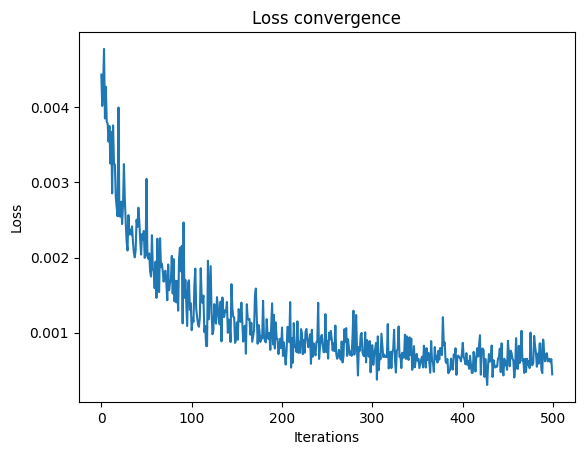

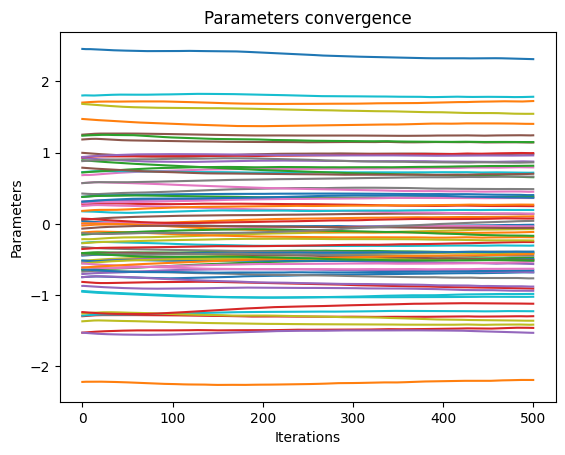

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime


timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
loss_image_path = f'./records/mnist/qsvdd/loss_{timestamp}.png'
params_text_path = f'./records/mnist/qsvdd/params_{timestamp}.txt'
params_image_path = f'./records/mnist/qsvdd/parameters_{timestamp}.png'

plt.style.use('default')
plt.plot(loss_history)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss convergence")
plt.savefig(loss_image_path)
plt.show()

np.savetxt(params_text_path, est_params, delimiter=',')

plt.plot(param_history)
plt.xlabel("Iterations")
plt.ylabel("Parameters")
plt.title("Parameters convergence")
plt.savefig(params_image_path)
plt.show()


# Test

In [12]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

def radius(data, center):
    res = []
    res.append(abs(data - center)**2)
    return res


In [13]:
import time
import numpy as np
import random
from sklearn.metrics import roc_curve, roc_auc_score

trained_params = est_params
y_true = []
y_pred = []

def test(ntrain, latent_dim):
    start_time = time.time()
    print(f"Starting test function with ntrain={ntrain}, latent_dim={latent_dim}")
    
    if cost_func == 'svdd':
        if latent_dim == 1:
            for i in range(10):
                step_start_time = time.time()
                if i == ntrain:
                    print(f"Processing class {ntrain} for latent_dim=1 with cost_func=svdd")
                    filter = np.where(y_test == ntrain)
                    test_data = x_test[filter]
                    idx_test = random.sample(range(len(test_data)), 100)
                    test_data = test_data[idx_test]
                    pred = np.asarray([QCNN(x, trained_params, U_params=num_params_conv,
                                            latent_dim=latent_dim, cost_fn=cost_func) for x in test_data])
                    for j in range(len(pred)):
                        y_pred.append((pred**2)[j])
                        y_true.append(0)
                else:
                    print(f"Processing class {i} for latent_dim=1 with cost_func=svdd")
                    filter = np.where(y_test == i)
                    test_data = x_test[filter]
                    idx_test = random.sample(range(len(test_data)), 10)
                    test_data = test_data[idx_test]
                    pred = np.asarray([QCNN(x, trained_params, U_params=num_params_conv,
                                            latent_dim=latent_dim, cost_fn=cost_func) for x in test_data])
                    for j in range(len(pred)):
                        y_pred.append((pred**2)[j])
                        y_true.append(1)
                step_end_time = time.time()
                print(f"Finished processing class {i} in {step_end_time - step_start_time:.2f} seconds")
        else:
            for i in range(10):
                step_start_time = time.time()
                if i == ntrain:
                    print(f"Processing class {ntrain} for latent_dim>1 with cost_func=svdd")
                    filter = np.where(y_test == ntrain)
                    test_data = x_test[filter]
                    idx_test = random.sample(range(len(test_data)), 100)
                    test_data = test_data[idx_test]
                    pred = np.asarray([QCNN(x, trained_params, U_params=num_params_conv,
                                            latent_dim=latent_dim, cost_fn=cost_func) for x in test_data])
                    for j in range(len(pred)):
                        y_pred.append((pred**2).mean(axis=1)[j])
                        y_true.append(0)
                else:
                    print(f"Processing class {i} for latent_dim>1 with cost_func=svdd")
                    filter = np.where(y_test == i)
                    test_data = x_test[filter]
                    idx_test = random.sample(range(len(test_data)), 10)
                    test_data = test_data[idx_test]
                    pred = np.asarray([QCNN(x, trained_params, U_params=num_params_conv,
                                            latent_dim=latent_dim, cost_fn=cost_func) for x in test_data])
                    for j in range(len(pred)):
                        y_pred.append((pred**2).mean(axis=1)[j])
                        y_true.append(1)
                step_end_time = time.time()
                print(f"Finished processing class {i} in {step_end_time - step_start_time:.2f} seconds")

    elif cost_func == 'qae':
        print("Calculating mean for QAE cost function")
        c_start_time = time.time()
        c = np.mean(np.asarray([QCNN(x, trained_params, U_params=num_params_conv, latent_dim=latent_dim,
                                     cost_fn=cost_func) for x in X_train]), axis=0)
        c_end_time = time.time()
        print(f"Calculated mean in {c_end_time - c_start_time:.2f} seconds")

        if latent_dim == 1:
            for i in range(10):
                step_start_time = time.time()
                if i == ntrain:
                    print(f"Processing class {ntrain} for latent_dim=1 with cost_func=qae")
                    filter = np.where(y_test == ntrain)
                    test_data = x_test[filter]
                    idx_test = random.sample(range(len(test_data)), 100)
                    test_data = test_data[idx_test]
                    pred = np.asarray([QCNN(x, trained_params, U_params=num_params_conv,
                                            latent_dim=latent_dim, cost_fn=cost_func) for x in test_data])
                    for j in range(len(pred)):
                        y_pred.append(((pred - c)**2)[j])
                        y_true.append(0)
                else:
                    print(f"Processing class {i} for latent_dim=1 with cost_func=qae")
                    filter = np.where(y_test == i)
                    test_data = x_test[filter]
                    idx_test = random.sample(range(len(test_data)), 10)
                    test_data = test_data[idx_test]
                    pred = np.asarray([QCNN(x, trained_params, U_params=num_params_conv,
                                            latent_dim=latent_dim, cost_fn=cost_func) for x in test_data])
                    for j in range(len(pred)):
                        y_pred.append(((pred - c)**2)[j])
                        y_true.append(1)
                step_end_time = time.time()
                print(f"Finished processing class {i} in {step_end_time - step_start_time:.2f} seconds")
        else:
            for i in range(10):
                step_start_time = time.time()
                if i == ntrain:
                    print(f"Processing class {ntrain} for latent_dim>1 with cost_func=qae")
                    filter = np.where(y_test == ntrain)
                    test_data = x_test[filter]
                    idx_test = random.sample(range(len(test_data)), 100)
                    test_data = test_data[idx_test]
                    pred = np.asarray([QCNN(x, trained_params, U_params=num_params_conv,
                                            latent_dim=latent_dim, cost_fn=cost_func) for x in test_data])
                    for j in range(len(pred)):
                        y_pred.append(((pred - c)**2).mean(axis=1)[j])
                        y_true.append(0)
                else:
                    print(f"Processing class {i} for latent_dim>1 with cost_func=qae")
                    filter = np.where(y_test == i)
                    test_data = x_test[filter]
                    idx_test = random.sample(range(len(test_data)), 10)
                    test_data = test_data[idx_test]
                    pred = np.asarray([QCNN(x, trained_params, U_params=num_params_conv,
                                            latent_dim=latent_dim, cost_fn=cost_func) for x in test_data])
                    for j in range(len(pred)):
                        y_pred.append(((pred - c)**2).mean(axis=1)[j])
                        y_true.append(1)
                step_end_time = time.time()
                print(f"Finished processing class {i} in {step_end_time - step_start_time:.2f} seconds")

    print("Calculating ROC curve and AUC score")
    roc_start_time = time.time()
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    roc_end_time = time.time()
    print(f"Calculated ROC and AUC in {roc_end_time - roc_start_time:.2f} seconds")
    
    end_time = time.time()
    print(f"Finished test function with AUC={auc} in {end_time - start_time:.2f} seconds")
    
    return auc, y_pred, y_true, fpr, tpr

auc, y_pred, y_true, fpr, tpr = test(ntrain, latent_dim)
print("Test completed")


Starting test function with ntrain=0, latent_dim=9
Processing class 0 for latent_dim>1 with cost_func=svdd
Finished processing class 0 in 17.63 seconds
Processing class 1 for latent_dim>1 with cost_func=svdd
Finished processing class 1 in 1.82 seconds
Processing class 2 for latent_dim>1 with cost_func=svdd
Finished processing class 2 in 1.78 seconds
Processing class 3 for latent_dim>1 with cost_func=svdd
Finished processing class 3 in 1.77 seconds
Processing class 4 for latent_dim>1 with cost_func=svdd
Finished processing class 4 in 1.73 seconds
Processing class 5 for latent_dim>1 with cost_func=svdd
Finished processing class 5 in 1.74 seconds
Processing class 6 for latent_dim>1 with cost_func=svdd
Finished processing class 6 in 1.75 seconds
Processing class 7 for latent_dim>1 with cost_func=svdd
Finished processing class 7 in 1.76 seconds
Processing class 8 for latent_dim>1 with cost_func=svdd
Finished processing class 8 in 1.74 seconds
Processing class 9 for latent_dim>1 with cost_fu

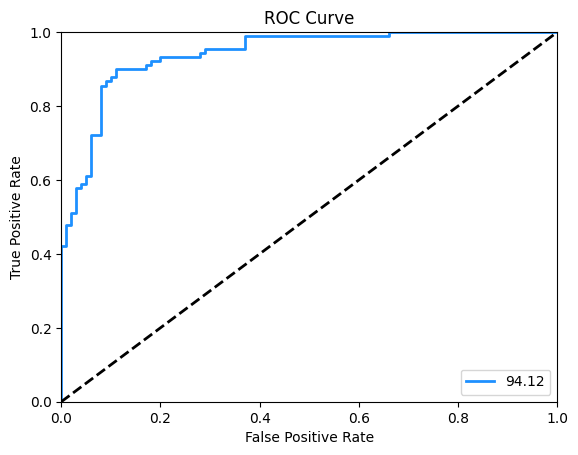

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import os


timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='dodgerblue', lw=lw, label="{:.2f}".format(auc * 100))
plt.plot([0, 1], [0, 1], color="black", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
roc_image_path = f'./records/mnist/qsvdd/roc_curve_{timestamp}.png'
plt.savefig(roc_image_path)
plt.show()


def save_auc_to_file(auc, file_name):
    auc = "{:.2f}".format(auc * 100)
    directory = os.path.dirname(file_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    if not os.path.exists(file_name):
        with open(file_name, 'w') as f:
            f.write("AUC Results\n")
    with open(file_name, 'a') as f:
        f.write(str(auc) + "\n")

auc_file_path = "./records/mnist/qsvdd/auc.txt"
save_auc_to_file(auc, auc_file_path)
